In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import shapiro
from scipy import stats as st
from time import time
import phik
import io
import datetime
from tqdm import tqdm

# Wind Turbine Scada Project

**Context**

In Wind Turbines, Scada Systems measure and save data's like wind speed, wind direction, generated power etc. for 10 minutes intervals. This file was taken from a wind turbine's scada system that is working and generating power in Turkey.


**The data's in the file are:**

- Date/Time (for 10 minutes intervals)
- LV ActivePower (kW): The power generated by the turbine for that moment
- Wind Speed (m/s): The wind speed at the hub height of the turbine (the wind speed that turbine use for electricity generation)
- Theoretical_Power_Curve (KWh): The theoretical power values that the turbine generates with that wind speed which is given by the turbine manufacturer
- Wind Direction (°): The wind direction at the hub height of the turbine (wind turbines turn to this direction automaticly)

## Чтение и анализ данных

In [2]:
wind_data= pd.read_csv('data/T1.csv')
wind_data.head()

,Date/Time,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°)
0,01 01 2018 00:00,380.047791,5.311336,416.328908,259.994904
1,01 01 2018 00:10,453.769196,5.672167,519.917511,268.641113
2,01 01 2018 00:20,306.376587,5.216037,390.900016,272.564789
3,01 01 2018 00:30,419.645905,5.659674,516.127569,271.258087
4,01 01 2018 00:40,380.650696,5.577941,491.702972,265.674286


In [3]:
## Информация о данных
wind_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50530 entries, 0 to 50529
Data columns (total 5 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Date/Time                      50530 non-null  object 
 1   LV ActivePower (kW)            50530 non-null  float64
 2   Wind Speed (m/s)               50530 non-null  float64
 3   Theoretical_Power_Curve (KWh)  50530 non-null  float64
 4   Wind Direction (°)             50530 non-null  float64
dtypes: float64(4), object(1)
memory usage: 1.9+ MB


In [4]:
## столбец Date/Time - точно временной ряд, надо его привести к соответствующему виде
wind_data['Date/Time'] = pd.to_datetime(wind_data['Date/Time'], format='%d %m %Y %H:%M', errors='coerce')
print ('Время начала измерений', min(wind_data['Date/Time']))
print ('Время окончания измерений', max(wind_data['Date/Time']))

Время начала измерений 2018-01-01 00:00:00
Время окончания измерений 2018-12-31 23:50:00


Тоесть выполнено 50530 замеров за год.

Пропусков нет, данные заполнены по всем стоблцам полностью

In [5]:
# Параметры числовых столбцов
wind_data.describe()

,Date/Time,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°)
count,50530,50530.000000,50530.000000,50530.000000,50530.000000
mean,2018-07-01 20:01:30.065307648,1307.684332,7.557952,1492.175463,123.687559
min,2018-01-01 00:00:00,-2.471405,0.000000,0.000000,0.000000
25%,2018-04-03 05:22:30,50.677890,4.201395,161.328167,49.315437
50%,2018-06-30 16:15:00,825.838074,7.104594,1063.776283,73.712978
75%,2018-09-26 18:57:30,2482.507568,10.300020,2964.972462,201.696720
max,2018-12-31 23:50:00,3618.732910,25.206011,3600.000000,359.997589
std,NaN,1312.459242,4.227166,1368.018238,93.443736


Интересно когда это активная мощность установки отрицательная

In [6]:
wind_data.loc[wind_data['LV ActivePower (kW)']<0].count()

Date/Time                        57
LV ActivePower (kW)              57
Wind Speed (m/s)                 57
Theoretical_Power_Curve (KWh)    57
Wind Direction (°)               57
dtype: int64

In [7]:
wind_data.loc[wind_data['LV ActivePower (kW)']<0].head()

,Date/Time,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°)
384,2018-01-03 16:00:00,-0.393068,2.185888,0.000000,238.410294
794,2018-01-06 15:50:00,-0.456533,2.949518,0.000000,204.901093
1402,2018-01-10 21:10:00,-0.038067,3.248698,28.906391,279.040100
1584,2018-01-12 03:40:00,-0.331467,2.574092,0.000000,214.811203
1589,2018-01-12 04:30:00,-0.959000,3.333948,35.608029,206.130402


## Работа с признаками

Добавим месяц в список признаком, неделя и день вероятно не важны, а вот месяц вполне возможно

In [8]:
wind_data['Month'] = wind_data['Date/Time'].dt.month
wind_data.head()

,Date/Time,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°),Month
0,2018-01-01 00:00:00,380.047791,5.311336,416.328908,259.994904,1
1,2018-01-01 00:10:00,453.769196,5.672167,519.917511,268.641113,1
2,2018-01-01 00:20:00,306.376587,5.216037,390.900016,272.564789,1
3,2018-01-01 00:30:00,419.645905,5.659674,516.127569,271.258087,1
4,2018-01-01 00:40:00,380.650696,5.577941,491.702972,265.674286,1


Добавил критерий точности оценки вырабатываемой электроэнергии

In [9]:
wind_data['Accuracy'] = abs(wind_data['LV ActivePower (kW)'] - wind_data['Theoretical_Power_Curve (KWh)'] )
wind_data.head(3)

,Date/Time,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°),Month,Accuracy
0,2018-01-01 00:00:00,380.047791,5.311336,416.328908,259.994904,1,36.281117
1,2018-01-01 00:10:00,453.769196,5.672167,519.917511,268.641113,1,66.148316
2,2018-01-01 00:20:00,306.376587,5.216037,390.900016,272.564789,1,84.523429


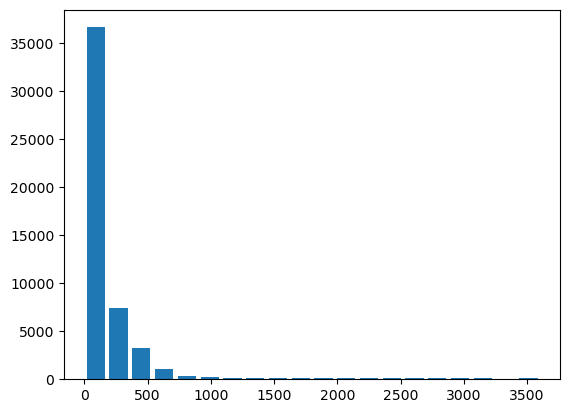

In [10]:
## посмотрим как распределена теперь точность мат.модели поставщика
plt.hist(wind_data['Accuracy'], density=False, rwidth=0.8, bins = 20)
plt.show()

In [11]:
## где-то есть разница в 300, нужно наверное посмотреть, что это - наверное можно прям, что совсем лишнее "грохнуть", но мы не будем
wind_data.loc[wind_data['Accuracy']>300].head(3)

,Date/Time,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°),Month,Accuracy
94,2018-01-01 15:40:00,2499.162109,10.14109,2876.753616,227.731598,1,377.591507
95,2018-01-01 15:50:00,2820.512939,10.77242,3186.029883,225.276398,1,365.516944
96,2018-01-01 16:00:00,2812.279053,10.64752,3133.259224,224.680603,1,320.980171


Добавим критерий направления ветра

In [12]:
compass_dirs = [
    "N", "NNE", "NE", "ENE",
    "E", "ESE", "SE", "SSE",
    "S", "SSW", "SW", "WSW",
    "W", "WNW", "NW", "NNW"
                ]
# Каждое направление содержит 22.5 градуса (их 16 штук)
# Так как 0 градусов это середина Севера, надо повернуть на 12.25, чтобы не мучаться с "хвостом"
bin_size  = 22.5
rot_aggle = bin_size/2

wind_data['Compass Direction'] = ((wind_data['Wind Direction (°)'] + 11.25) % 360).apply(
    lambda x: compass_dirs[int(x // bin_size)]
    )
wind_data.head()

,Date/Time,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°),Month,Accuracy,Compass Direction
0,2018-01-01 00:00:00,380.047791,5.311336,416.328908,259.994904,1,36.281117,W
1,2018-01-01 00:10:00,453.769196,5.672167,519.917511,268.641113,1,66.148316,W
2,2018-01-01 00:20:00,306.376587,5.216037,390.900016,272.564789,1,84.523429,W
3,2018-01-01 00:30:00,419.645905,5.659674,516.127569,271.258087,1,96.481664,W
4,2018-01-01 00:40:00,380.650696,5.577941,491.702972,265.674286,1,111.052276,W


**Этапы работы ветровой турбины по скорости ветра:**

***Стартовая скорость (2.5–4 м/с):*** Это диапазон скоростей, при котором лопасти ветроколеса начинают вращаться, приводя в движение генератор, но мощность еще невелика.

***Рабочая зона (примерно 4–10 м/с):*** С ростом скорости ветра мощность турбины постепенно увеличивается.

***Номинальная мощность (10–14 м/с):*** При этих скоростях турбина достигает своей проектной, максимальной мощности.

***Снижение выработки (от 15 м/с):*** После достижения номинальной скорости, выработка энергии может снизиться, хотя турбина все еще работает.

***Отключение и остановка (более 20–25 м/с):*** При достижении высоких скоростей ветра, которые могут быть опасны для оборудования, ветровая турбина автоматически останавливается. Ветроколесо переводится в флюгерное положение, чтобы снизить нагрузку и предотвратить повреждение

In [13]:
def get_wind_power(row):
    if row['Wind Speed (m/s)'] < 2.5:
        return 'zero'
    if  2.5 <= row['Wind Speed (m/s)'] < 4.0:
        return 'start'
    if  4.0 <= row['Wind Speed (m/s)'] < 10.0:
        return 'cut-in'
    if  10.0 <= row['Wind Speed (m/s)'] < 14.0:
        return 'rate-wind'
    if  14.0 <= row['Wind Speed (m/s)'] < 20.0:
        return 'cut-out'
    else:
        return 'critical'

In [14]:
wind_data['Wind_power_group'] = wind_data.apply(get_wind_power, axis=1)
wind_data.head(5)

,Date/Time,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°),Month,Accuracy,Compass Direction,Wind_power_group
0,2018-01-01 00:00:00,380.047791,5.311336,416.328908,259.994904,1,36.281117,W,cut-in
1,2018-01-01 00:10:00,453.769196,5.672167,519.917511,268.641113,1,66.148316,W,cut-in
2,2018-01-01 00:20:00,306.376587,5.216037,390.900016,272.564789,1,84.523429,W,cut-in
3,2018-01-01 00:30:00,419.645905,5.659674,516.127569,271.258087,1,96.481664,W,cut-in
4,2018-01-01 00:40:00,380.650696,5.577941,491.702972,265.674286,1,111.052276,W,cut-in


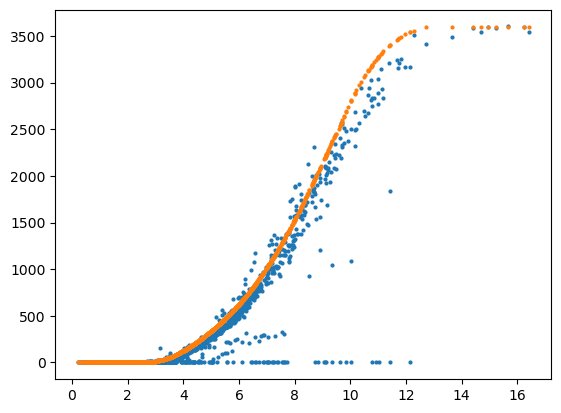

In [15]:
## Давайте построим графики по направлениям W
data2W = wind_data.loc[wind_data['Compass Direction']=='W']
plt.plot(data2W['Wind Speed (m/s)'], data2W['LV ActivePower (kW)'], 'o', markersize=2)
plt.plot(data2W['Wind Speed (m/s)'], data2W['Theoretical_Power_Curve (KWh)'], 'o', markersize=2)
plt.show()

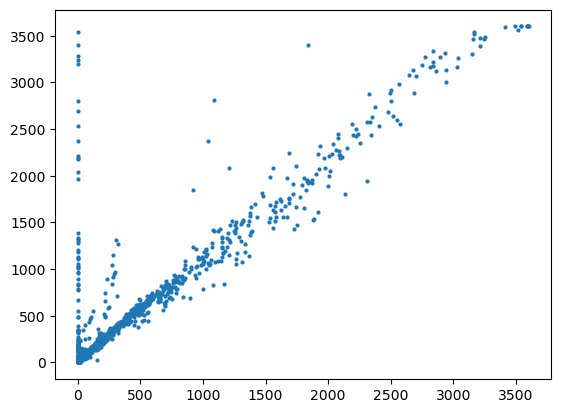

In [16]:
plt.plot(data2W['LV ActivePower (kW)'], data2W['Theoretical_Power_Curve (KWh)'], 'o', markersize=2)
plt.show()

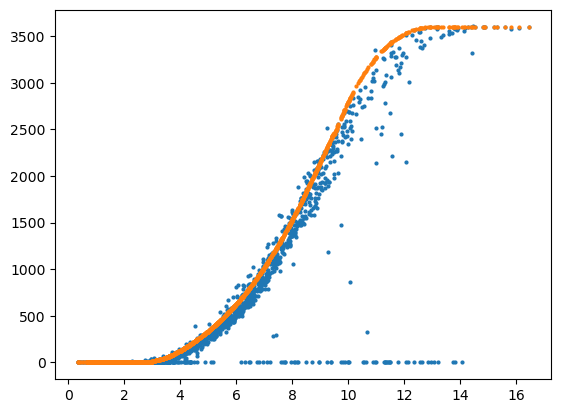

In [17]:
## Давайте построим графики по направлениям WSW
data2WSW = wind_data.loc[wind_data['Compass Direction']=='WSW']
plt.plot(data2WSW['Wind Speed (m/s)'], data2WSW['LV ActivePower (kW)'], 'o', markersize=2)
plt.plot(data2WSW['Wind Speed (m/s)'], data2WSW['Theoretical_Power_Curve (KWh)'], 'o', markersize=2)

## Анализ признаков

In [18]:
## создаем список названия столбцов для трансформации
num_features = ['Wind Speed (m/s)', 'Wind Direction (°)', 'Month', 'Accuracy']
cat_features = ['Compass Direction', 'Wind_power_group']
targets = ['Theoretical_Power_Curve (KWh)', 'LV ActivePower (kW)']

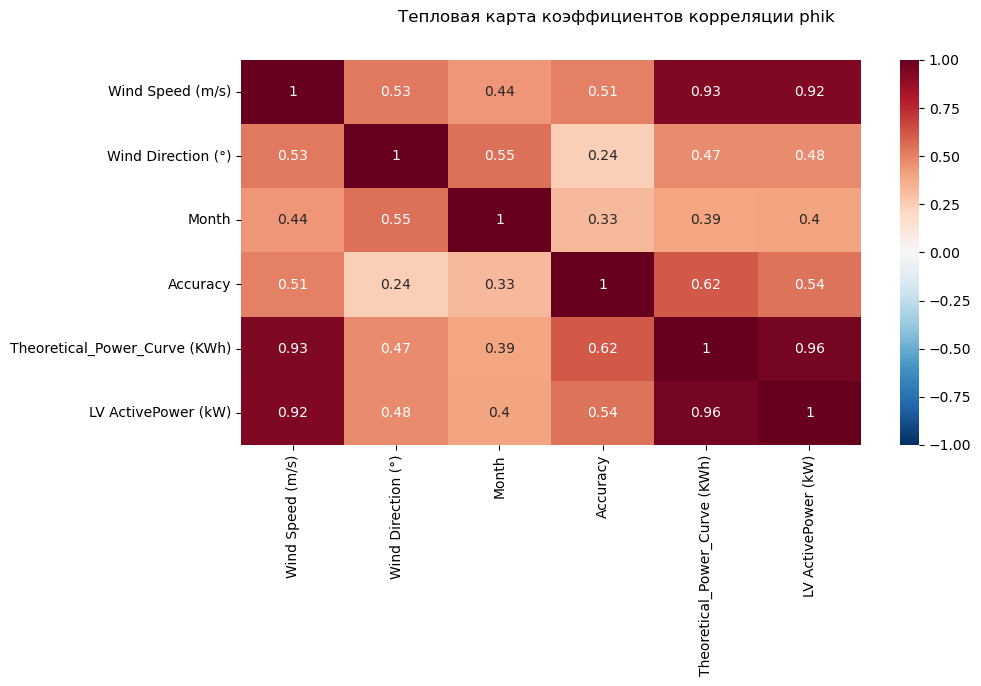

In [19]:
fig, ax = plt.subplots(figsize=(10, 5))
data2pik = wind_data[num_features+targets].phik_matrix(interval_cols= num_features+targets);
sns.heatmap(
    data2pik,        
    cmap='RdBu_r',                
    annot=True,
    vmin=-1, vmax=1              
);
fig.suptitle('Тепловая карта коэффициентов корреляции phik');

In [20]:
## у нас два катерагиальных признака, давайте посмотрим, различается что то по ним или нет
numbycat1 = np.append(num_features+targets, 'Wind_power_group')  
numbycat2 = np.append(num_features+targets, 'Compass Direction') 

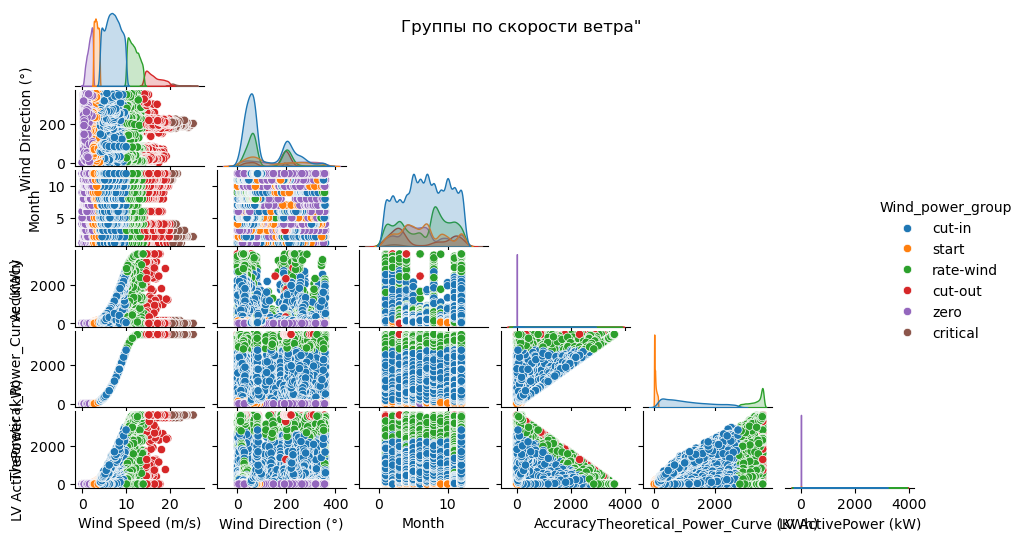

In [21]:
g = sns.pairplot(wind_data[numbycat1], hue="Wind_power_group", corner=True)
g.fig.suptitle('Группы по скорости ветра"');
g.fig.subplots_adjust(top = 1)
g.fig.set_size_inches(10, 5)
plt.show()

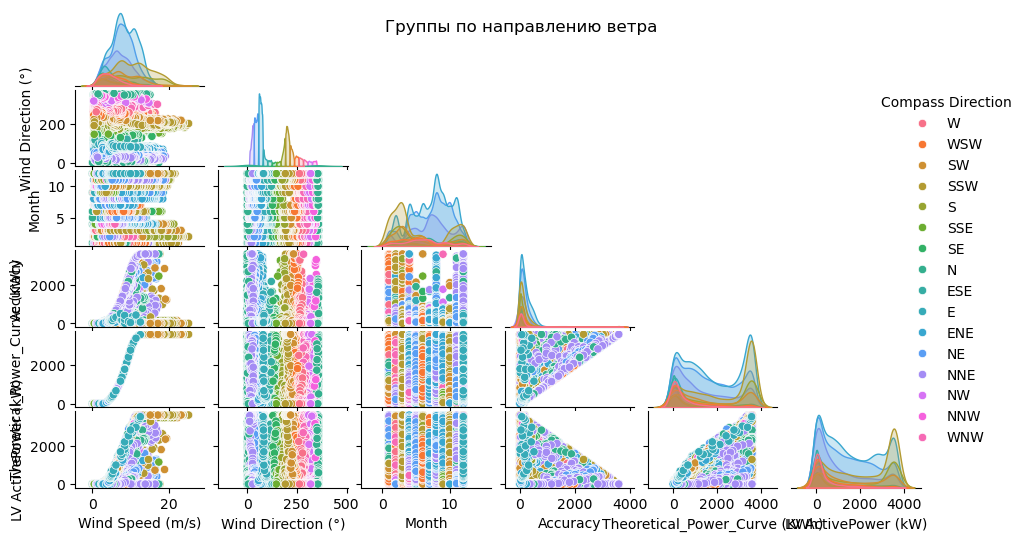

In [22]:
g = sns.pairplot(wind_data[numbycat2], hue="Compass Direction", corner=True)
g.fig.suptitle('Группы по направлению ветра');
g.fig.subplots_adjust(top = 1)
g.fig.set_size_inches(10, 5)
plt.show()

## Обучение модели

In [23]:
# pipelines
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
# подготовка данных
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
# метрики регрессии
from sklearn.metrics import  mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score

In [24]:
# Константы
RANDOM_STATE = 80424     # константа для генерирации псевдослучайных величин
TEST_SIZE = 0.25         # размер тестовой выборки

In [25]:
## Создадим pipeline - обработки, который будет преобразовывать признаки для использования в модели
num_steps = [('SimpleImputer_num', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0)),
             ('Scaler', StandardScaler())]
ohe_steps = [('SimpleImputer_cat', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
             ('Coder', OneHotEncoder(drop='first', handle_unknown='ignore'))]
cat_transformer = Pipeline(ohe_steps)
num_transformer = Pipeline(num_steps)

In [26]:
# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(transformers=[
                                                    ('num', num_transformer, num_features),
                                                    ('cat', cat_transformer, cat_features)],        
                                       remainder  ='passthrough')
data_preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('num',
                                 Pipeline(steps=[('SimpleImputer_num',
                                                  SimpleImputer(fill_value=0,
                                                                strategy='constant')),
                                                 ('Scaler', StandardScaler())]),
                                 ['Wind Speed (m/s)', 'Wind Direction (°)',
                                  'Month', 'Accuracy']),
                                ('cat',
                                 Pipeline(steps=[('SimpleImputer_cat',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('Coder',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'))]),
                                 ['Compass Direction', 'Wind_power_group'])])

In [27]:
# Создаем функци для полного pipeline - чтобы подкидывать разные модели 
def regression_model(model):
    return Pipeline([
        ('preprocessor', data_preprocessor),
        ('model', model)
    ])

In [28]:
data4calc = wind_data.drop(columns = ['Date/Time'])
data4calc.head(3)

,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°),Month,Accuracy,Compass Direction,Wind_power_group
0,380.047791,5.311336,416.328908,259.994904,1,36.281117,W,cut-in
1,453.769196,5.672167,519.917511,268.641113,1,66.148316,W,cut-in
2,306.376587,5.216037,390.900016,272.564789,1,84.523429,W,cut-in


In [29]:
## Разделем данные на тестовые и обучающие
X_train, X_test, y_train, y_test = train_test_split(
                                                    data4calc[num_features+cat_features], 
                                                    data4calc['LV ActivePower (kW)'], 
                                                    test_size = TEST_SIZE,
                                                    random_state=RANDOM_STATE)

In [30]:
user_defined = LinearRegression(n_jobs=-1)
lin_model  = regression_model(user_defined)
# визуализация pipeline
lin_model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('SimpleImputer_num',
                                                                   SimpleImputer(fill_value=0,
                                                                                 strategy='constant')),
                                                                  ('Scaler',
                                                                   StandardScaler())]),
                                                  ['Wind Speed (m/s)',
                                                   'Wind Direction (°)',
                                                   'Month', 'Accuracy']),
                                                 ('cat',
                                                  Pipeline(steps=[('SimpleImputer_cat',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('Coder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['Compass Direction',
                                                   'Wind_power_group'])])),
                ('model', LinearRegression(n_jobs=-1))])

In [31]:
# Обучение
lin_model.fit(X_train, y_train)
# Предсказание
y_pred = lin_model.predict(X_test)

In [32]:
# Оценка качества на кросс-валидации
mae_accure_cv = cross_val_score(
    lin_model,
    X_train,
    y_train,
    scoring='r2',
    cv=5,
    n_jobs=-1
).mean()
print('Точность модели на тренировочной выборке: R2 = ', abs(mae_accure_cv))

Точность модели на тренировочной выборке: R2 =  0.9662313306449904


## Перебор моделей с параметрами

Исследуем следующие модели:

* RandomForestRegressor() ;
* CatBoostRegressor() ;
* LightGBM();
* DecisionTreeRegressor();
* Ridge();
* Lasso()

In [33]:
# модели
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.dummy import DummyRegressor
from catboost import CatBoostRegressor
from sklearn.tree import  DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, StackingRegressor, GradientBoostingRegressor
from lightgbm import LGBMRegressor

In [34]:
def param_grid_choose(type_of_model, learning_rate, num_leaves, max_bin, n_estimators, max_depth, min_samples_split, min_samples_leaf, alpha, max_depth_cat):
# типы моделей
    if type_of_model == 'LightGBM':
        # словарь для модели LightGBM
        param_grid = [{
        'model': [LGBMRegressor(verbose=-1, n_jobs = -1)],
        'model__num_leaves': num_leaves,
        'model__max_depth': max_depth,
        'model__max_bin': max_bin
                     }] 
    elif type_of_model == 'RandomForestRegressor':
        # словарь для модели RandomForestRegressor   
        param_grid = [{
        'model': [RandomForestRegressor(n_jobs=-1, random_state=RANDOM_STATE)],
        'model__n_estimators': n_estimators, 
        'model__max_depth': max_depth,
        'model__min_samples_split': min_samples_split,
        'model__min_samples_leaf': min_samples_leaf 
            }]
    elif type_of_model == 'CatBoostRegressor':
        # словарь для модели CatBoostRegressor   
        param_grid = [{
        'model': [CatBoostRegressor(iterations=1000, random_state=RANDOM_STATE, loss_function='MAE', logging_level ='Silent')],
        'model__learning_rate': learning_rate,
        'model__max_depth': max_depth_cat,
        'model__max_bin': max_bin
                    }]
    elif type_of_model == 'DecisionTreeRegressor':
        # словарь для модели DecisionTreeClassifier
        param_grid = [{
        'model': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'model__max_depth': max_depth,
        'model__min_samples_split': min_samples_split,
        'model__min_samples_leaf': min_samples_leaf,
        'model__max_features': max_features          
                     }]
    elif type_of_model == 'Ridge':
        # словарь для модели Ridge 
         param_grid = [{
        'model': [Ridge(random_state=RANDOM_STATE)],
        'model__alpha': alpha
                      }]  
    elif type_of_model == 'Lasso':
        # словарь для модели Lasso
        param_grid = [{
        'model': [Lasso(random_state=RANDOM_STATE)],
        'model__alpha': alpha
                    }]
    return param_grid

Зададим диапазон параметров для исследования

In [35]:
# CatBoostRegressor & LightGBM parameters
learning_rate       = [0.1, 0.25, 0.5, 0.75]
num_leaves          = range(2, 35)
max_bin             = [100, 150, 200, 250, 300]
max_depth_cat       = range(2, 16)
# RandomForestRegressor & DecisionTreeRegressor parameters
n_estimators        = [10, 100, 150] # default 100     
max_depth           = range(2, 35)
min_samples_split   = range(2, 35)
min_samples_leaf    = range(2, 35)
max_features        = range(2, 35)
# Ridge&Lasso parameters
alpha               = [0.1, 0.15, 0.2,  0.25, 0.5, 0.75, 1, 10, 25, 50, 75, 100]     # default 100

In [36]:
model_list = ['LightGBM' , 'RandomForestRegressor', 'CatBoostRegressor', 'DecisionTreeRegressor', 'Ridge', 'Lasso']
model_list = ['LightGBM' , 'RandomForestRegressor', 'DecisionTreeRegressor', 'Ridge', 'Lasso']
model_list = ['DecisionTreeRegressor']
metrics_reg = []
for i, model in tqdm(enumerate(model_list)):
    time2start = time()
    params   = param_grid_choose(model, learning_rate, num_leaves, max_bin, n_estimators, max_depth, min_samples_split, min_samples_leaf, alpha, max_depth_cat)
    searcher = RandomizedSearchCV(lin_model, 
                              param_distributions = params, 
                              cv=5,
                              scoring='neg_mean_absolute_error',
                              random_state=RANDOM_STATE,
                              error_score='raise',
                              n_iter=10,
                              n_jobs=-1);
    searcher.fit(X_train, y_train)
    train_score = abs(searcher.best_score_)
    time2finish = time()
    dt = time2finish-time2start
    metrics_reg.append([model, train_score, str(searcher.best_estimator_.get_params()["model"]), 
                    round(dt, 2), round(searcher.cv_results_['mean_fit_time'].mean(), 2), round(searcher.cv_results_['mean_score_time'].mean(), 2), 
                    searcher.best_estimator_["model"].get_params()])
    print (model+' done')
metrics_reg = pd.DataFrame(metrics_reg)
metrics_reg.columns = ['model_list', 'MAE', 'Лучшая модель', 'Время подбора гиперпараметров, сек', 'Время обучения модели, сек', 'Время предсказания модели, сек', 'Все параметры модели']
metrics_reg.index  = model_list
metrics_reg

1it [00:02,  2.55s/it]

DecisionTreeRegressor done


,model_list,MAE,Лучшая модель,"Время подбора гиперпараметров, сек","Время обучения модели, сек","Время предсказания модели, сек",Все параметры модели
DecisionTreeRegressor,DecisionTreeRegressor,23.130605,"DecisionTreeRegressor(max_depth=18, max_featur...",2.55,0.4,0.01,"{'ccp_alpha': 0.0, 'criterion': 'squared_error..."


In [37]:
searcher.best_estimator_.get_params()["model"]

DecisionTreeRegressor(max_depth=18, max_features=32, min_samples_leaf=3,
                      min_samples_split=22, random_state=80424)

In [38]:
# Итоговая модель 
user_defined = LGBMRegressor(max_bin=250, max_depth=16, n_jobs=-1, num_leaves=32, verbose=-1)
best_model  = regression_model(user_defined)
# визуализация pipeline
best_model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('SimpleImputer_num',
                                                                   SimpleImputer(fill_value=0,
                                                                                 strategy='constant')),
                                                                  ('Scaler',
                                                                   StandardScaler())]),
                                                  ['Wind Speed (m/s)',
                                                   'Wind Direction (°)',
                                                   'Month', 'Accuracy']),
                                                 ('cat',
                                                  Pipeline(steps=[('SimpleImputer_cat',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('Coder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['Compass Direction',
                                                   'Wind_power_group'])])),
                ('model',
                 LGBMRegressor(max_bin=250, max_depth=16, n_jobs=-1,
                               num_leaves=32, verbose=-1))])

In [39]:
# Обучение
best_model.fit(X_train, y_train)
# Предсказание
y_pred = best_model.predict(X_test)

In [40]:
# Оценка качества на кросс-валидации
mae_accure_cv = cross_val_score(
    best_model,
    X_train,
    y_train,
    scoring='neg_mean_absolute_error',
    cv=5,
    n_jobs=-1
).mean()
print('Точность модели на тренировочной выборке: MAE = ', abs(mae_accure_cv))

Точность модели на тренировочной выборке: MAE =  17.848027046797654


## Анализ полученных результатов


In [41]:
# Оценка качества на кросс-валидации
mae_accure_cv = cross_val_score(
    best_model,
    X_train,
    y_train,
    scoring='r2',
    cv=5,
    n_jobs=-1
).mean()
print('Точность модели на тренировочной выборке: R2 = ', abs(mae_accure_cv))

Точность модели на тренировочной выборке: R2 =  0.9990096149176388


Положительные значения R² показывает, в скольких процентах случаев (здесь около 99.9) предсказание модели ближе к истине, чем среднее значение целевого признака.

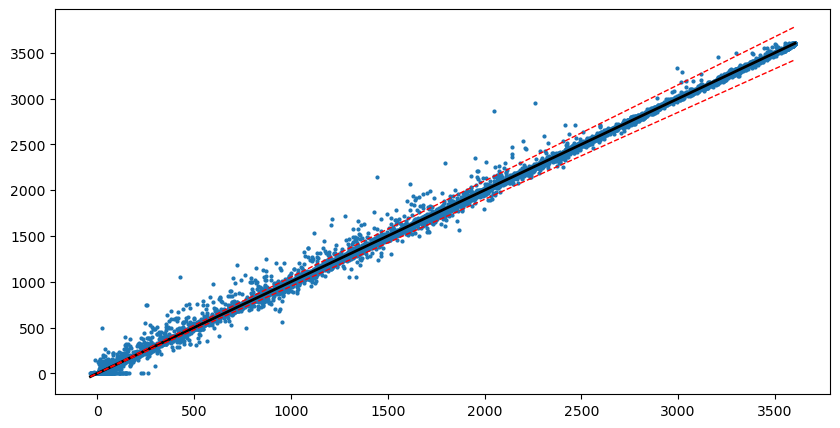

In [42]:
plt.figure(figsize=(10, 5))
plt.plot(y_pred, y_test, 'o', markersize=2)
# Линия идеального предсказания (y = x)
x_line = np.linspace(min(y_pred), max(y_pred), 100)
plt.plot(x_line, x_line, 'k-', linewidth=2, label='Ideal prediction')
#  ±5% 
plt.plot(x_line, x_line * 1.05, 'r--', linewidth=1, label='+5%')
plt.plot(x_line, x_line * 0.95, 'r--', linewidth=1, label='-5%')
plt.show()

Анализ остатков

Значение p-value для теста Шапиро = 2.97E-100


C:\Users\int\.conda\envs\ICengine_theory_st\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 12633.
  res = hypotest_fun_out(*samples, **kwds)


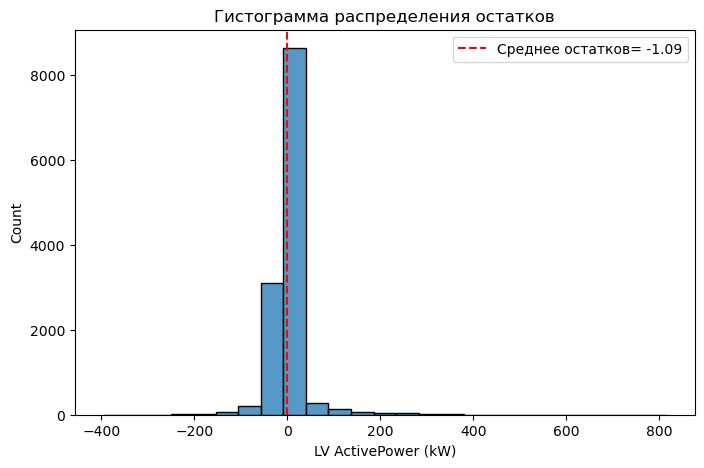

In [43]:
residuals = y_test-y_pred
tst=shapiro(residuals)
print(f'Значение p-value для теста Шапиро = {tst.pvalue:.2E}');
plt.figure(figsize=(8,5))
sns.histplot(data=residuals, bins = 25)
plt.axvline(x = residuals.mean(), color = 'r', linestyle='dashed', label = 'Среднее остатков= ' +str(round(residuals.median(),2)))
plt.title ('Гистограмма распределения остатков')
plt.legend()
plt.show()

Оценим постоянство дисперсии


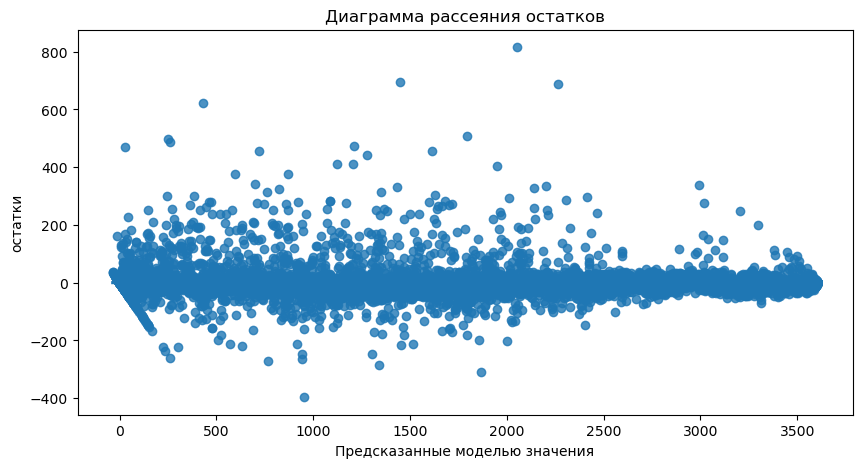

In [44]:
plt.figure(figsize=(10,5))
p=sns.regplot(x=y_pred, y=residuals)
p.set(
        title='Диаграмма рассеяния остатков',
        xlabel='Предсказанные моделью значения',
        ylabel='остатки'
    )
plt.show()

Распределение остатков равномерно, но присутсвуют выбросы слева. Если "подчистить" данные в процессе их анализа (грохнуть около нулевые стремные значения), можно было бы постараться этого избежать.